In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from torchvision import transforms
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn



from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from torch.nn import Sequential as Seq

from tqdm import tqdm

sys.path.append('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation')
from onegraph_rest_free_graphds import OneGraphDS
from gan_based_models import Discriminator
from second_stage_vig_based_models import FullModel
from vig_based_functions import act_layer, get_multi_shot_set
from vig_graph_modules import GraphEncoderBlockSE, GrapherSetEdges
from perceptual_loss import VGGPerceptualLoss

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing f

In [2]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [3]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances.pk1', 'rb') as handle:
    patch_distances = pickle.load(handle)

In [ ]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

In [ ]:
data["all_tiles"].shape

# LW Ind Implemented

In [4]:
A, T, _, _, _ = data["tiles"].shape

lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.4)[0]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 0)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 3)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 12)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 15)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]
data["tile_cluster"] = data["tile_cluster"][lw_ind]
data["all_tiles"] = data["all_tiles"][lw_ind]

img_ind = [[x for _ in range(T)] for x in range(A)]

img_ind = torch.Tensor(np.array(img_ind)).flatten().to(torch.int)

img_ind = img_ind[lw_ind]

In [ ]:
print(lw_ind.shape)
print(pos_ind.shape)
print(img_ind.shape)
print(data["tile_cluster"].shape)
print(data["all_tiles"].shape)

In [ ]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

In [ ]:
unique, counts = np.unique(pos_ind, return_counts=True)
for x in zip(unique, counts):
    print(x)


In [ ]:
unique, counts = np.unique(img_ind, return_counts=True)
counts

## Remove White Patches

In [ ]:
ind = np.where(data["tile_cluster"][lw_ind] != 1)[0]

In [ ]:
n_ind = np.where(data["tile_cluster"] == 1)[0]

In [ ]:
n=0

In [ ]:
data["all_tiles"][ind].shape

In [ ]:
per = np.sum(data["all_tiles"][ind] == 255)/(56*56*3*1824)
per*100

In [ ]:
hist = []
for x in data["all_tiles"][ind]:
    hist.append(np.sum(x == 255)/(56*56*3))

In [ ]:
print(np.quantile(hist, 0.25))
print(np.quantile(hist, 0.75))
plt.boxplot(hist)
plt.show

In [ ]:
plt.hist(hist, density=True, bins = 5)

In [ ]:
n += 1
print(100*(np.sum(data["all_tiles"][ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][ind][n])

In [ ]:
lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.75)[0]
print(lw_ind.shape)

In [ ]:
n=0

In [ ]:
n += 1
print(n)
print(100*(np.sum(data["all_tiles"][lw_ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][lw_ind][n])

In [ ]:
data["tile_images"].shape

In [ ]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

In [ ]:
unique, counts = np.unique(data["tile_cluster"][lw_ind], return_counts=True)
counts

## Pre-Calculate path distances

In [ ]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [ ]:
data["all_tiles"] = torch.Tensor(data["all_tiles"]/255)
data["all_tiles"] = data["all_tiles"].to("cuda:7")

In [ ]:
data["all_tiles"].shape

In [ ]:
dist = VGGPerceptualLoss().to("cuda:7")

In [ ]:
l = dist(train_tiles[0].reshape(1,3,56,56), train_tiles[10].reshape(1,3,56,56))

In [ ]:
l.backward()

In [ ]:
per_distances = []
euc_distances = []
N_SHOTS = 2
i = 0
with torch.no_grad():
    for avg in tqdm(data["all_tiles"]):
        i += 1
        per_aux = []
        euc_aux = []
        for img in tqdm(data["all_tiles"][i:]):
            per_aux.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1, 2, 3]))
            euc_aux.append(torch.dist(avg, img))
        
        per_aux = torch.Tensor(per_aux)
        per_distances.append(per_aux)
        
        euc_aux = torch.Tensor(euc_aux)
        euc_distances.append(euc_aux)
        
        del per_aux, euc_aux
        

    #distances = torch.Tensor(distances)
    

In [ ]:
patch_distances = {"perception_distances":per_distances, "euclidean_distances":euc_distances}
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances_backup.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(len(per_distances))
print(len(euc_distances))

In [ ]:
print(per_distances[1039])

In [ ]:
#
"""
the following python list is populated by tensors that represent the upper triangle of a distance matrix (position 0,300 is the distance between nodes 0 and 300 but 300,0 does not exist as that would be part of the lower triangle). This means that each tensor in the array is of a different length (each succesive tensor is 1 value smaller as that distance value is captured in the tensors above it), which means the full array cannot be converted to a torch tensor. Write a code that fills out the matrix with all distances both upper and lower triangles (both 0,300 and 300,0 should have the same value ie the distance between nodes 0 and 300). Diagonals should be 0 as these would be the distances between a node and itself. When appending a row, the difference in length of each tensor must be fixed before appending into the full matrix. The array's name is - patch_distances["perception_distances"]



do not include comments, code explanations etc only just the code that does the function required

This error coming up due to not fixing the tensor length, that is, not making up for the distances covered in the above tensors for 1 tensor



---------------------------------------------------------------------------RuntimeError Traceback (most recent call last)Cell In[72], line 6 3 full_matrix = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype) 5 for i, row_data in enumerate(data_list):----> 6 full_matrix[i, i+1:] = row_data 7 full_matrix[i+1:, i] = row_dataRuntimeError: The expanded size of the tensor (1039) must match the existing size (1038) at non-singleton dimension 0. Target sizes: [1039]. Tensor sizes: [1038]
"""

data_list = patch_distances["perception_distances"]
num_nodes = len(data_list[0]) + 1
full_matrix_per = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype)

for i, row_data in enumerate(data_list):
    n = row_data.size(0)
    full_matrix_per[i, num_nodes-n:] = row_data
    full_matrix_per[num_nodes-n:, i] = row_data

In [ ]:
data_list = patch_distances["euclidean_distances"]
num_nodes = len(data_list[0]) + 1
full_matrix_euc = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype)

for i, row_data in enumerate(data_list):
    n = row_data.size(0)
    full_matrix_euc[i, num_nodes-n:] = row_data
    full_matrix_euc[num_nodes-n:, i] = row_data

In [ ]:
torch.equal(full_matrix_euc, full_matrix_euc.T)

In [ ]:
full_matrix_per.shape

In [ ]:
patch_distances = {"perception_distances":full_matrix_per, "euclidean_distances":full_matrix_euc}
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances_backup.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del dist

## Dist Testing

In [ ]:
distances = []
N_SHOTS = 2
i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    search_cluster = data["tile_cluster"][i]
    cluster_space = np.where(data["tile_cluster"] == search_cluster)[0]
    for img in tqdm(data["all_tiles"][cluster_space]):
        distances.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1, 2, 3]))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(cluster_space[indices])
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][cluster_space[indices][1]].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][cluster_space[indices][1]]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][cluster_space[indices][2]].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][cluster_space[indices][2]]))
axes[2].axis('off')
plt.show()
    

In [ ]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    for img in tqdm(data["all_tiles"]):
        distances.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1]))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(indices)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][indices][1].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][indices][1]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][indices][2].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][indices][2]))
axes[2].axis('off')
plt.show()

In [ ]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    search_cluster = data["tile_cluster"][i]
    cluster_space = np.where(data["tile_cluster"] == search_cluster)[0]
    for img in data["all_tiles"][cluster_space]:
        distances.append(torch.dist(avg, img))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(cluster_space[indices])
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][cluster_space[indices][1]].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][cluster_space[indices][1]]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][cluster_space[indices][2]].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][cluster_space[indices][2]]))
axes[2].axis('off')
plt.show()
    

In [ ]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    for img in data["all_tiles"]:
        distances.append(torch.dist(avg, img))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(indices)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][indices][1].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][indices][1]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][indices][2].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][indices][2]))
axes[2].axis('off')
plt.show()

# Model Training

In [5]:
NUM_SAMPLES_PER_GRAPH = 100
NUM_LINES = 4
NUM_NEIGHBORS = 5
NUM_BLOCK_LOOPS = 2
NUM_BLOCKS_PER_HEAD = 2
EDGE_METHOD = "KNN"
DELETION_THRESHOLD = 0.5
GET_BASE_TILES = True
N_SHOTS = 2
DEVICE = "cuda:7" if torch.cuda.is_available() else "cpu"
ATTENTION_HEADS = 4
ACTIVATION_TYPE = "relu"

EPOCHS = 200
LR = 0.0001
D_LR = 0.0001
BATCH_SIZE = 100
K = 2
KP = 5
REAL_LABEL = 1
FAKE_LABEL = 0
SWITCH_THRESHOLD = -1

NUM_GRAPH_NODES = 600

GAN_FREQ = 1
GAN_DISC_FREQ = 50

In [6]:
DEVICE

'cuda:7'

In [7]:
train_images = torch.Tensor(data['image']).to(torch.float32)
train_images = (train_images - torch.min(train_images))/(torch.max(train_images) - torch.min(train_images))

train_tiles = torch.Tensor(data['all_tiles']).to(torch.float32)
train_tiles = (train_tiles - torch.min(train_tiles))/(torch.max(train_tiles) - torch.min(train_tiles))

train_tiles_clusters = torch.Tensor(data['tile_cluster']).to(torch.int)

In [ ]:
i=0
print(lw_ind[i])
print(pos_ind[i])
print(img_ind[i])
print(train_tiles[i].shape)
print(train_tiles_clusters[i])

# Gen Only model (Stage 3)

In [8]:
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device=x.device)
        return x + self.weight * noise

In [9]:
class GrapherSetEdges(nn.Module):
    def __init__(self, in_channels, img_dim, drop_path=0.0, device = "cuda:7"):
        super(GrapherSetEdges, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = gnn.GraphConv(in_channels*img_dim*img_dim, in_channels*img_dim*img_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.device = device

    def forward(self, x, edge_index):
        _tmp = x
        B,C,H,W = x.shape
        x = self.fc1(x)
        x = x.reshape(B,-1)
        x = self.graph_conv(x, edge_index)
        x = x.reshape(B,-1,H,W)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [1]:
class FFN(nn.Module):
    def __init__(self, in_features, act='relu', drop_path=0.0):
        super().__init__()
        out_features = in_features
        hidden_features = in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x


NameError: name 'nn' is not defined

In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, in_dim=3, out_channels=128, img_dim = 6, device="cuda:7"):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_channels, 3, stride=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            
            #nn.Conv2d(out_dim//2, out_dim, 3, stride=1, padding=1),
        )
        self.graphblock = GrapherSetEdges(out_channels, img_dim, device=device)
        

    def forward(self, x, edge_index):
        x = self.convs(x)
        x = self.graphblock(x, edge_index)
        return x

In [11]:
class GeneratorBlock(nn.Module):
    def __init__(self, in_channels = 128, out_channels = 3, img_dim = 7, device="cuda:7"):
        super(GeneratorBlock, self).__init__()
        self.graphblock = GrapherSetEdges(in_channels, img_dim, device=device)
        self.inject_noise = InjectNoise(in_channels)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3, 3, dilation = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            
            nn.Conv2d(out_channels, out_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            #nn.ConvTranspose2d(in_channels//8, out_channels, 1, 1, dilation = 1),
            #nn.Sigmoid()
        )

    def forward(self, x, edge_index):
        x = self.graphblock(x, edge_index)
        x = self.inject_noise(x[0].unsqueeze(0))
        x = self.model(x)
        return x

In [12]:
class GraphUNET(nn.Module):
    def __init__(self, in_channels, out_channels, img_dim, at_heads = 4, device = "cuda:7"):
        super(GraphUNET, self).__init__()
        self.encblock1 = EncoderBlock(in_channels, out_channels//2, img_dim*3)
        self.encblock2 = EncoderBlock(out_channels//2, out_channels, img_dim)
        
        self.genblock2 = GeneratorBlock(out_channels, out_channels//2, img_dim, device)
        self.genblock1 = GeneratorBlock(out_channels//2, out_channels//16, img_dim*3, device)
        
        self.out = nn.Sequential(
            nn.Conv2d(out_channels//16, in_channels, 1, 1, padding=1),
            nn.Sigmoid()
        )
        

    def forward(self, x, graph, edge_index):
        r1 = self.encblock1(graph, edge_index[0])
        r2 = self.encblock2(r1, edge_index[0])
        
        x = torch.cat([x,r2], dim = 0)
        x = self.genblock2(x, edge_index[1])
        x = torch.cat([x,r1], dim = 0)
        x = self.genblock1(x, edge_index[1])
        return self.out(x[0])

In [13]:
edge_index = [torch.Tensor([[0,0],[1,2]]).to(torch.long).to(DEVICE),
              torch.Tensor([[0,0,0],[1,2,3]]).to(torch.long).to(DEVICE)]
loss = VGGPerceptualLoss().to(DEVICE)
best = [0, np.Inf]

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model = GraphUNET(3, 128, 6, 2, device = DEVICE)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

## Testing

In [ ]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/1st_model.pickle"
model.load_state_dict(torch.load(SAVE_PATH, weights_only=True))


In [26]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:1000].reshape(-1, BATCH_SIZE)
    for tr_ind in train_index:
        optimizer.zero_grad()
        
        out = torch.topk(patch_distances["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []
        for input in batch:
            break
        break
    break

In [ ]:
tr_ind[:3]

In [ ]:
input = train_tiles[[1023,370,189]]

### Save Models

In [ ]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/1st_noise_model_more_train.pickle"
torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/1st_noise_model_more_train_backup.pickle"
torch.save(model.state_dict(), SAVE_PATH)

### Testing

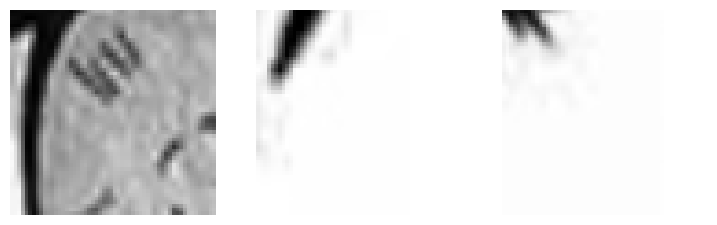

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(input[0].cpu())
axes[0].axis('off')

axes[1].imshow(input[1].cpu())
axes[1].axis('off')

axes[2].imshow(input[2].cpu())
axes[2].axis('off')
plt.show()

In [35]:
input.shape

torch.Size([3, 56, 56, 3])

torch.Size([3, 64, 18, 18])
torch.Size([3, 128, 6, 6])
torch.Size([1, 128, 6, 6])
torch.Size([3, 128, 6, 6])
torch.Size([4, 128, 6, 6])
torch.Size([4, 64, 18, 18])


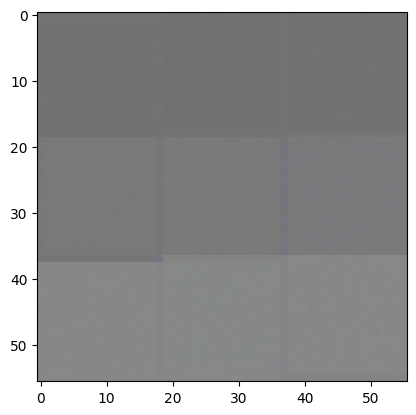

In [60]:
model.eval()
with torch.no_grad():
    noise = torch.randn(1, 128, 6, 6, device=DEVICE)
    pred = model(noise, input.reshape(3,3,56,56).to(DEVICE), edge_index)
    
plt.imshow(pred.cpu().detach().numpy().reshape(56,56,3), cmap="grey")
plt.show()

In [ ]:
tr_ind = tr_ind.T.copy() 
tr_ind = torch.from_numpy(tr_ind).to(DEVICE)

In [ ]:
train_tiles[tr_ind].reshape(K+1, BATCH_SIZE, 3, 56, 56).shape

In [ ]:
loss(pred, train_tiles[tr_ind].reshape(K+1, BATCH_SIZE, 3, 56, 56))

## Training Loop

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:1000].reshape(-1, BATCH_SIZE)
    i=0
    for tr_ind in tqdm(train_index):
        noise = torch.randn(BATCH_SIZE, 128, 6, 6, device=DEVICE)
        
        i+=1
        
        out = torch.topk(patch_distances["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []

        for input, x in zip(batch, noise):
            input = input.to(DEVICE)
            aux = model(x.unsqueeze(0), input.reshape(3,3,56,56), edge_index)
            pred.append(aux.unsqueeze(0))
            
            del aux, input
        

        pred = torch.cat(pred, dim=0)
        target = train_tiles[out].reshape(3, 100, 3, 56, 56).to(DEVICE)
        
        pcl = 0.8*loss(pred, target[0].reshape(-1, 3, 56, 56))
        pcl += 0.1*loss(pred, target[1].reshape(-1, 3, 56, 56))
        pcl += 0.1*loss(pred, target[2].reshape(-1, 3, 56, 56))
        del pred, noise, target
        optimizer.zero_grad()
        pcl.backward()
        optimizer.step()
        running_loss += pcl.item()
        
    print("Percetion Loss: ",running_loss/i)

In [15]:
d_model = Discriminator(3, 128)
d_model = d_model.to(DEVICE)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr = LR)
loss_func = nn.BCEWithLogitsLoss()

In [22]:
GAN_DISC_FREQ = 1
SWITCH_THRESHOLD = -1

In [24]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([[x for x in range(train_tiles.shape[0])] for _ in range(K+1)])
    for tr_ind in train_index:
        np.random.shuffle(tr_ind)

    train_index = train_index.T[:1000].reshape(-1,BATCH_SIZE,K+1)
    i=0
    
    for tr_ind in tqdm(train_index):
        noise = torch.randn(BATCH_SIZE, 128, 6, 6, device=DEVICE)
        i+=1
        
        batch = train_tiles[tr_ind]
        pred = []

        for input, x in zip(batch, noise):
            input = input.to(DEVICE)
            aux = model(x.unsqueeze(0), input.reshape(3,3,56,56), edge_index)
            pred.append(aux)
            del aux, input

        pred = torch.cat(pred, dim=0)
        tr_ind = tr_ind.T.copy() 
        tr_ind = torch.from_numpy(tr_ind)

        label = torch.full((BATCH_SIZE,), REAL_LABEL, dtype=torch.float, device=DEVICE)
        for p in d_model.parameters():
            p.requires_grad = True
        
        target = train_tiles[tr_ind][0].reshape(BATCH_SIZE, 3, 56, 56).to(DEVICE)
        
        d_real_pred = d_model(target).view(-1)
        d_real_loss = loss_func(d_real_pred, label)
        drl = d_real_loss.mean().item()
        
        label_fake = torch.full((BATCH_SIZE,), FAKE_LABEL, dtype=torch.float, device=DEVICE)
        d_fake_pred = d_model(pred.detach().reshape(100,3,56,56)).view(-1)
        d_fake_loss = loss_func(d_fake_pred, label_fake)
        dfl = d_fake_loss.mean().item()

        if epoch%GAN_DISC_FREQ == 0.0:
            d_loss = (d_real_loss + d_fake_loss)/2
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
        
        for p in d_model.parameters():
            p.requires_grad = False
        
        optimizer.zero_grad()
        d_g_pred = d_model(pred.reshape(100,3,56,56)).view(-1)
        del pred
        d_g_loss = loss_func(d_g_pred, label)
        dgl = d_g_loss.mean().item()
        
        d_g_loss.backward()
        optimizer.step()
        
        
        
    if epoch >= SWITCH_THRESHOLD and epoch%GAN_FREQ == 0.0:
        print("Discrimor:", dfl+drl)
        print("Generator:", dgl)

Epoch: 0


100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


Discrimor: 1.2414074540138245
Generator: 2.193467140197754
Epoch: 1


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


Discrimor: 0.505744993686676
Generator: 3.4928207397460938
Epoch: 2


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.4389732927083969
Generator: 4.233623504638672
Epoch: 3


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.11043206602334976
Generator: 4.988692760467529
Epoch: 4


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.054724663496017456
Generator: 5.647676944732666
Epoch: 5


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.04365951754152775
Generator: 5.272009372711182
Epoch: 6


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.03304153401404619
Generator: 6.37879753112793
Epoch: 7


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.010769801796413958
Generator: 5.964209079742432
Epoch: 8


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.016175174852833152
Generator: 4.936518669128418
Epoch: 9


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.002155388123355806
Generator: 7.7889404296875
Epoch: 10


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.011214772006496787
Generator: 6.1758012771606445
Epoch: 11


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00489282701164484
Generator: 7.668049335479736
Epoch: 12


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.0014931207988411188
Generator: 7.87019157409668
Epoch: 13


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.007296571042388678
Generator: 6.401513576507568
Epoch: 14


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


Discrimor: 0.003975187508331146
Generator: 6.489041805267334
Epoch: 15


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0017599401180632412
Generator: 7.104407787322998
Epoch: 16


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.003878734161844477
Generator: 6.537299156188965
Epoch: 17


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.02502065058797598
Generator: 4.781481742858887
Epoch: 18


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.00011057016672566533
Generator: 10.320405006408691
Epoch: 19


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00019927031098632142
Generator: 9.616630554199219
Epoch: 20


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0013983407097839518
Generator: 6.839898586273193
Epoch: 21


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.00536959117744118
Generator: 7.466530799865723
Epoch: 22


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.002960835467092693
Generator: 7.390297889709473
Epoch: 23


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.0014340333145810291
Generator: 7.318933010101318
Epoch: 24


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.0012082316943633487
Generator: 7.159295082092285
Epoch: 25


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.036212548166417946
Generator: 5.0504608154296875
Epoch: 26


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 1.0225704954791581e-05
Generator: 12.762008666992188
Epoch: 27


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


Discrimor: 3.593683800318104e-05
Generator: 12.756393432617188
Epoch: 28


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0002065138796751853
Generator: 10.101375579833984
Epoch: 29


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.001870240934067624
Generator: 6.4753289222717285
Epoch: 30


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0012003449955955148
Generator: 7.93938684463501
Epoch: 31


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.0011321202237013495
Generator: 8.067837715148926
Epoch: 32


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 4.6280792957986705e-05
Generator: 10.390185356140137
Epoch: 33


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.000528591498834885
Generator: 7.717127323150635
Epoch: 34


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.001260030633147835
Generator: 7.268249988555908
Epoch: 35


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.08833332371432334
Generator: 5.608023643493652
Epoch: 36


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 3.113792172371177e-05
Generator: 11.93777847290039
Epoch: 37


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 4.69319820695091e-06
Generator: 13.154242515563965
Epoch: 38


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 1.7626097815082176e-05
Generator: 11.31515121459961
Epoch: 39


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.00022404309405033018
Generator: 8.464252471923828
Epoch: 40


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.0012128702969107508
Generator: 7.10510778427124
Epoch: 41


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.0005886229773750529
Generator: 7.974277019500732
Epoch: 42


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.001241186816400841
Generator: 7.199649333953857
Epoch: 43


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.000655515421385644
Generator: 7.775064468383789
Epoch: 44


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.0007437310850946233
Generator: 7.7161865234375
Epoch: 45


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0012624435969428305
Generator: 6.229961395263672
Epoch: 46


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00015702589757893293
Generator: 9.399651527404785
Epoch: 47


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 7.131960956030525e-05
Generator: 10.412482261657715
Epoch: 48


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0011436157583375461
Generator: 6.62180757522583
Epoch: 49


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


Discrimor: 0.00034826723822334316
Generator: 8.61430549621582
Epoch: 50


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00013288394575283746
Generator: 9.028534889221191
Epoch: 51


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.0007132355586350059
Generator: 7.396597862243652
Epoch: 52


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0005089287407145093
Generator: 7.968942165374756
Epoch: 53


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0005422827150027842
Generator: 7.770041465759277
Epoch: 54


100%|██████████| 10/10 [00:56<00:00,  5.65s/it]


Discrimor: 0.0004551634606286825
Generator: 8.055424690246582
Epoch: 55


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0006142466590972617
Generator: 7.5646562576293945
Epoch: 56


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00047167334400910477
Generator: 8.06689453125
Epoch: 57


100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


Discrimor: 0.0003491759271128103
Generator: 8.476754188537598
Epoch: 58


100%|██████████| 10/10 [00:56<00:00,  5.64s/it]


Discrimor: 0.0035471985465846956
Generator: 7.844437122344971
Epoch: 59


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0007086462210281752
Generator: 7.738935470581055
Epoch: 60


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0007129008154151961
Generator: 8.463762283325195
Epoch: 61


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.0008878943990566768
Generator: 7.4089579582214355
Epoch: 62


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]


Discrimor: 0.00021371504226408433
Generator: 8.798449516296387
Epoch: 63


 40%|████      | 4/10 [00:28<00:42,  7.06s/it]


KeyboardInterrupt: 

In [ ]:
train_tiles[tr_ind].shape

In [ ]:
EPOCHS = 250

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:1000].reshape(-1, BATCH_SIZE)
    for tr_ind in tqdm(train_index):
        optimizer.zero_grad()
        
        out = torch.topk(patch_distances["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []

        for input in batch:
            aux = model(input.reshape(3,3,56,56), edge_index)
            pred.append(aux)
            del aux, input

        pred = torch.cat(pred, dim=0)
        out = out.cpu().numpy()
        out = out.T.copy() 
        out = torch.from_numpy(out).to(DEVICE)
        
        pcl = 0.333*loss(pred, train_tiles[out][0].reshape(-1, 3, 56, 56))
        pcl += 0.333*loss(pred, train_tiles[out][1].reshape(-1, 3, 56, 56))
        pcl += 0.333*loss(pred, train_tiles[out][2].reshape(-1, 3, 56, 56))
        del pred
        pcl.backward()
        optimizer.step()
        running_loss += pcl.item()
        
    print("Percetion Loss: ",running_loss/BATCH_SIZE)

In [ ]:
train_tiles[out].shape

In [ ]:
i=-1

In [ ]:
out_euc[0]

In [ ]:
#i+=1
out_per = torch.topk(patch_distances["perception_distances"][train_index[0]][i], K+1, largest=False).indices[1::]
out_euc = torch.topk(patch_distances["euclidean_distances"][train_index[0]][i], K+1, largest=False).indices[1::]
print(train_index[0][i])
print(out_per)
print(out_euc)
out = torch.cat([out_per,out_euc])

In [ ]:
out.shape[0]>3

In [ ]:
torch.topk(patch_distances["perception_distances"][train_index[0]], K+1, largest=False)

# Gen Model Training Loop (2nd Stage)

In [ ]:
del model

In [ ]:
model = FullModel(16 ,N_SHOTS, NUM_BLOCK_LOOPS, NUM_BLOCKS_PER_HEAD, 3, 48, 7, 4)
model = model.to(DEVICE)

In [ ]:
d_model = Discriminator(3, 512)
d_model = d_model.to(DEVICE)

In [ ]:
model = FullModel(16 ,N_SHOTS, NUM_BLOCK_LOOPS, NUM_BLOCKS_PER_HEAD, 3, 48, 7, 4)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr = LR)
loss_func = nn.BCEWithLogitsLoss()
mse_loss_func = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
  print(epoch)
  B,T,H,W,C = all_query_tiles.shape
  model.train()
  running_loss = 0.0
  count = 0
  #graph_indeces = np.random.choice(np.array([x for x in range(B)]),
  #                                 size=GRAPH_BATCH_SIZE, replace=False)

  train_indeces = np.random.choice(np.array([x for x in range(B)]),
                                   size=EPOCH_BATCH_SIZE, replace=False)
  train_indeces = train_indeces.reshape(-1, TRAIN_BATCH_SIZE)


  graph_sample = train_tiles.reshape(-1, 3, 56, 56)
  graph_sample = graph_sample.unsqueeze(0).expand(TRAIN_BATCH_SIZE, -1, 3, 56, 56)
  #B,_,H,W,C = graph_sample.shape
  #graph_sample = graph_sample.reshape(B*T,C,H,W)

  for i in train_indeces:
    #query_tiles = all_query_tiles[i].reshape(TRAIN_BATCH_SIZE, T,C,H,W)
    query_img = train_images[i].reshape(TRAIN_BATCH_SIZE, 3,224,224)

    input = graph_sample #torch.cat([query_tiles, graph_sample], dim=1)

    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
    query_img = query_img.to(DEVICE)
    input = input.to(DEVICE)

    if epoch>SWITCH_THRESHOLD:
      d_optimizer.zero_grad()

      label = torch.full((TRAIN_BATCH_SIZE,), REAL_LABEL, dtype=torch.float, device=DEVICE)
      d_real_pred = d_model(query_img).view(-1)
      d_real_loss = loss_func(d_real_pred, label)
      drl = d_real_loss.mean().item()

    pred = []

    for j in tqdm(input):
      aux = model(query_img, j, T, NUM_NEIGHBORS, EDGE_METHOD)
      pred.append(aux)
      del aux

    pred = torch.cat(pred, dim=0)

    if epoch > SWITCH_THRESHOLD:

      label_fake = torch.full((TRAIN_BATCH_SIZE,), FAKE_LABEL, dtype=torch.float, device=DEVICE)
      d_fake_pred = d_model(pred.detach()).view(-1)
      d_fake_loss = loss_func(d_fake_pred,label_fake)
      dfl = d_fake_loss.mean().item()

      d_loss = (d_real_loss + d_fake_loss)/2
      d_loss.backward()
      d_optimizer.step()

      optimizer.zero_grad()
      d_g_pred = d_model(pred).view(-1)
      d_g_loss = loss_func(d_g_pred, label)
      dgl = d_g_loss.mean().item()

    #g_mse_loss = mse_loss_func(pred, query_img)
    #gml = g_mse_loss.mean().item()

    if epoch > SWITCH_THRESHOLD:

      #g_loss = d_g_loss# + g_mse_loss*0.75
      #g_loss.backward()
      d_g_loss.backward()
      optimizer.step()
      print("Discrimor:", dfl+drl)
      print("Generator:", dgl)
      #print("Generator MSE:", gml)

    else:
      #g_mse_loss.backward()
      optimizer.step()
      #print("Generator:", gml)

In [ ]:
pred.dtype

In [ ]:
i = 25
B,T,H,W,C = all_query_tiles.shape
query_tiles = all_query_tiles[i].reshape(T,C,H,W)
query_img = train_images[i].reshape(1,3,224,224)
mask = torch.arange(train_images.shape[0]) != i
graph_sample = train_tiles.reshape(-1, 3, 56, 56)
input = torch.cat([query_tiles, graph_sample], dim=0)

indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
query_img = query_img.to(DEVICE)
input = input.to(DEVICE)

In [ ]:
print(query_img.shape)
print(input.shape)

In [ ]:
with torch.no_grad():
  out = model(query_img, input, T, NUM_NEIGHBORS, EDGE_METHOD)

In [ ]:
out.shape

In [ ]:
plt.imshow(out.reshape(224,224,3).detach().cpu().numpy())
plt.show()

In [ ]:
plt.imshow(query_img.reshape(224,224,3).detach().cpu().numpy())
plt.show()

In [ ]:
for i in range(train_images.shape[0]):
  with torch.no_grad():
    B,T,H,W,C = train_tiles.shape
    query_img = train_tiles[i].reshape(T,C,H,W)
    mask = torch.arange(train_images.shape[0]) != i
    graph_sample = train_tiles[np.random.choice(train_index[mask], NUM_SAMPLES_PER_GRAPH, replace=False)]
    B,_,H,W,C = graph_sample.shape
    graph_sample = graph_sample.reshape(B*T,C,H,W)
    input = torch.cat([query_img, graph_sample], dim=0)
    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])

  #Insert Stem Model to get embeddings

  for loop in range(NUM_BLOCK_LOOPS):
    input = model(input, T, NUM_NEIGHBORS, EDGE_METHOD)

    with torch.no_grad():
      input, t_indeces = get_past_threshold(input, T, DELETION_THRESHOLD)
      indeces = indeces[t_indeces]

  n_shot_indices = []
  with torch.no_grad():
    full_set, shot_set, remaining_indeces, shot_indices = get_multi_shot_set(input, T, N_SHOTS)
    for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
    n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)
    indeces = indeces[remaining_indeces]


  #Insert Generative Model


  break


In [ ]:
full_set, shot_set, remaining_indeces, shot_indices  = get_multi_shot_set(input, T, N_SHOTS)

In [ ]:
train_images.shape

In [ ]:
train_tiles.shape

In [ ]:
n_shot_indices=[]
with torch.no_grad():
  for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
  n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)

In [ ]:
n_shot_indices

In [ ]:
shot_indices

In [ ]:
full_set.shape

In [ ]:
shot_set.shape

In [ ]:
indeces

In [ ]:
grapher_model = Grapher(3, 4).to("cuda")

In [ ]:
out = grapher_model(input, NUM_NEIGHBORS, EDGE_METHOD)

In [ ]:
out.shape

In [ ]:
indeces.shape

In [ ]:
indeces

In [ ]:
t_indeces.shape

In [ ]:
graph_sample[indeces.to(torch.int)].shape

In [ ]:
input.shape

In [ ]:
shot_set.shape

In [ ]:
full_set.shape

In [ ]:
T

In [ ]:
edge_index.shape

In [ ]:
graph_sample.shape

In [ ]:
query_img.shape

In [ ]:
input.shape